Variational Autoencoders - Janusz Markiewicz

#1. Data Prep

## Imports

In [ ]:
!pip install minisom matplotlib

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.backend as K
from keras.callbacks import Callback
from collections import defaultdict
import random
import os
from sklearn.datasets import fetch_openml
from minisom import MiniSom
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For progress bar

## Parameters

In [ ]:
SEED = 51
BATCH_SIZE = 32
IMG_WIDTH  = 28
IMG_HEIGHT = 28

## Prepare the Data

In [ ]:
X_mnist, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

split

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting into training and testing sets (80-20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X_mnist, y, test_size=0.2, random_state=42)

# Further splitting the training set into training and validation sets (90-10 split of the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Splitting the temporary testing set into actual testing set (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



check

In [ ]:
# Print shapes of the datasets
print("Training set (X_train, y_train):", X_train.shape, y_train.shape)
print("Validation set (X_val, y_val):", X_val.shape, y_val.shape)
print("Testing set (X_test, y_test):", X_test.shape, y_test.shape)


Training set (X_train, y_train): (50400, 784) (50400,)
Validation set (X_val, y_val): (7000, 784) (7000,)
Testing set (X_test, y_test): (7000, 784) (7000,)


organize mnist by label into subdirectories

In [ ]:
def save_images_to_directory(data, labels, folder_name):
    # Create directory for data
    os.makedirs(folder_name, exist_ok=True)

    # Save images to corresponding subdirectories
    for img, label in tqdm(zip(data, labels), total=len(data), desc=f"Saving images to {folder_name}"):
        label_folder = os.path.join(folder_name, label)
        img_name = str(np.random.randint(1e8)) + '.png'  # random name to avoid conflicts
        img_path = os.path.join(label_folder, img_name)
        img_reshaped = img.reshape(28, 28)  # Reshape image to 28x28
        plt.imsave(img_path, img_reshaped, cmap='gray')  # Save image

# Save training, validation, and testing images to directories
save_images_to_directory(X_train, y_train, 'train')
save_images_to_directory(X_val, y_val, 'val')
save_images_to_directory(X_test, y_test, 'test')


Saving images to test: 100%|██████████████████████████████████████████████████████| 7000/7000 [00:17<00:00, 404.63it/s]


In [ ]:
def check_data_structure(folder_name):
    """
    Check the data structure for the given folder.

    Args:
    - folder_name (str): The name of the folder to check.
    """
    # Get the list of class label subdirectories
    class_subdirectories = os.listdir(folder_name)

    # Loop through each class label subdirectory and count the number of images
    for class_subdir in class_subdirectories:
        class_folder = os.path.join(folder_name, class_subdir)
        num_images = len(os.listdir(class_folder))
        print(f"Class {class_subdir}: {num_images} images")

    print('\n')

# Example usage:
check_data_structure('train')  # Check the structure of the training data
check_data_structure('val')    # Check the structure of the validation data
check_data_structure('test')   # Check the structure of the testing data

Class 0: 29144 images
Class 1: 32347 images
Class 2: 29102 images
Class 3: 29266 images
Class 4: 28585 images
Class 5: 25981 images
Class 6: 28216 images
Class 7: 29927 images
Class 8: 28124 images
Class 9: 28556 images


Class 0: 4635 images
Class 1: 5328 images
Class 2: 4524 images
Class 3: 4788 images
Class 4: 4502 images
Class 5: 4331 images
Class 6: 4685 images
Class 7: 5156 images
Class 8: 4703 images
Class 9: 4675 images


Class 0: 2665 images
Class 1: 3178 images
Class 2: 2779 images
Class 3: 2784 images
Class 4: 2572 images
Class 5: 2486 images
Class 6: 2692 images
Class 7: 2758 images
Class 8: 2517 images
Class 9: 2843 images




In [ ]:
def list_subdirectories(root_dir):
    subdirectories = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for dirname in dirnames:
            subdirectories.append(os.path.join(dirpath, dirname))
    return subdirectories


subdirectories = list_subdirectories('train')
print(subdirectories)
subdirectories = list_subdirectories('val')
print(subdirectories)
subdirectories = list_subdirectories('test')
print(subdirectories)

['train\\0', 'train\\1', 'train\\2', 'train\\3', 'train\\4', 'train\\5', 'train\\6', 'train\\7', 'train\\8', 'train\\9']
['val\\0', 'val\\1', 'val\\2', 'val\\3', 'val\\4', 'val\\5', 'val\\6', 'val\\7', 'val\\8', 'val\\9']
['test\\0', 'test\\1', 'test\\2', 'test\\3', 'test\\4', 'test\\5', 'test\\6', 'test\\7', 'test\\8', 'test\\9']


In [ ]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

# Training data generator
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  seed=np.random.seed(42),
  labels="inferred"
)

# Validation data generator
validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  seed=np.random.seed(42),
  labels="inferred"
)

# Testing data generator
testing_generator = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  seed=np.random.seed(42),
  labels="inferred"
)

Found 188455 files belonging to 10 classes.
Found 20298 files belonging to 10 classes.
Found 20274 files belonging to 10 classes.


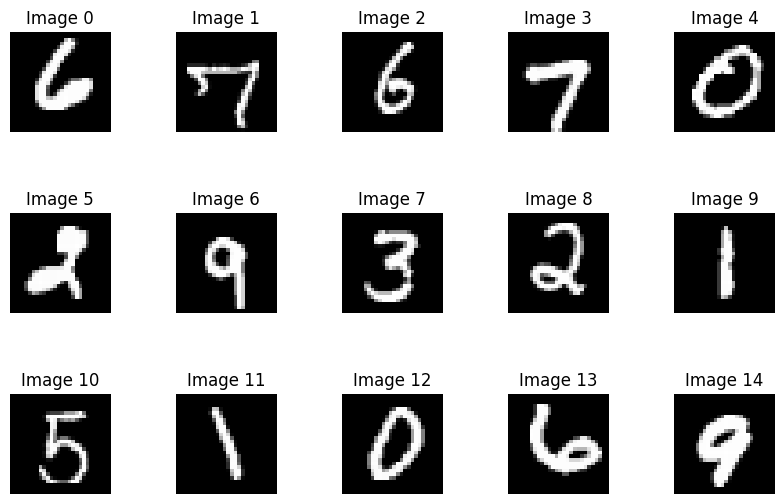

In [ ]:
# Function to scale images to the range [0, 1]
def scale_images(images):
    return images / 255

# Function to replicate inputs to outputs
def replicate_io(images):
    scaled_images = scale_images(images)
    return scaled_images, scaled_images

# create prefetch generators
training_generator = training_generator.prefetch(64)
validation_generator = validation_generator.prefetch(64)
test_generator = test_generator.prefetch(64)


# apply to each batch
X_train = training_generator.map(replicate_io)
X_val = validation_generator.map(replicate_io)
X_test = test_generator.map(replicate_io)



# get few images for visualizations
images, _ = next(iter(X_test.take(1)))
comparison_images = images.numpy()[:15]

# Display images for selection
plt.figure(figsize=(10, 6))

for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(comparison_images[i])
    plt.title(f"Image {i}")
    plt.axis("off")

plt.subplots_adjust(wspace=0.5, hspace=0.8)
plt.show()

In [ ]:
# Select few images for later on
IMAGE_SELECTION = [0, 1, 2, 4, 5]

# 2. Build VAE Model

## Sampling layer

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, input_values):
        mean, log_var = input_values

        random_samples = K.random_normal(tf.shape(log_var))

        std_dev = K.exp(log_var / 2) #ensures positive std_dev

        sampled_values = random_samples * std_dev + mean

        return sampled_values

##VAE Constructor

In [ ]:
def build_encoder(input_shape, encoding_size, depth):
    input_image = keras.layers.Input(shape=input_shape)
    encoder_output = input_image

    kernel_initializer = 'he_normal'
    for i in range(depth):
        encoder_output = keras.layers.Conv2D(32 * (2 ** i), kernel_size=3, strides=2,
                                            padding='same', activation='gelu',
                                            kernel_initializer=kernel_initializer)(encoder_output)

    encoder_output = keras.layers.Flatten()(encoder_output)

    dense_layer_mean = keras.layers.Dense(encoding_size)
    dense_layer_log_var = keras.layers.Dense(encoding_size)

    codings_mean = dense_layer_mean(encoder_output)
    codings_log_var = dense_layer_log_var(encoder_output)

    codings = Sampling()([codings_mean, codings_log_var])

    encoder_model = keras.Model(inputs=[input_image], outputs=[codings_mean, codings_log_var, codings])
    return encoder_model

In [ ]:
def build_decoder(encoding_size, depth, output_shape):
    decoder_input = keras.layers.Input(shape=[encoding_size])
    decoder_output = decoder_input

    dense_units = int((32 * (2 ** (depth - 1))) * output_shape[0] / (2 ** (depth - 1)) * output_shape[1] / (2 ** (depth - 1)))
    decoder_output = keras.layers.Dense(units=dense_units,
                                        activation='gelu')(decoder_output)

    reshape_details = [int(output_shape[0] / (2 ** (depth - 1))),
                      int(output_shape[1] / (2 ** (depth - 1))),
                      int(32 * (2 ** (depth - 1)))]
    decoder_output = keras.layers.Reshape(target_shape=reshape_details)(decoder_output)

    for i in range(depth - 1):
        decoder_output = keras.layers.Conv2DTranspose(filters=32 * 2 ** (depth - i - 2), kernel_size=3, strides=2,
                                                      padding='same', activation='gelu')(decoder_output)

    reconstructed_output = keras.layers.Conv2DTranspose(filters=output_shape[-1], kernel_size=3,
                                                         padding='same', activation='sigmoid')(decoder_output)

    decoder_model = keras.Model(inputs=[decoder_input], outputs=[reconstructed_output])
    return decoder_model

In [ ]:
def compute_latent_loss(codings_mean, codings_log_var, beta):
    latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1) * beta
    return K.mean(latent_loss)

In [ ]:
def vae_builder(input_shape, encoding_size, depth, beta, summarize=False):
    encoder_model = build_encoder(input_shape, encoding_size, depth)
    decoder_model = build_decoder(encoding_size, depth, input_shape)

    encoder_input = encoder_model.input
    _, _, latent_representation = encoder_model(encoder_input)

    reconstructed_output = decoder_model(latent_representation)

    vae = keras.Model(inputs=[encoder_model.input], outputs=[reconstructed_output])

    if summarize:
        encoder_model.summary()
        decoder_model.summary()
        vae.summary()

    # add a loss function
    latent_loss = compute_latent_loss(latent_representation[0], latent_representation[1], beta)
    vae.add_loss(latent_loss)

    return vae

#3. Seek Best parameters

## Architecture Search

In [ ]:
EPOCHS = 1
ENCODING_SIZES = [8, 16, 32] #
DEPTHS = [2, 3, 4] #
BETA_VALUES = [0.00001, 0.001, 0.01, 1] #,

In [ ]:
def exponential_decay(epoch):
    initial_learning_rate = 0.001
    decay_factor = 0.95
    decay_rate = 10
    return initial_learning_rate * decay_factor ** (epoch / decay_rate)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay)

reconstruction_storage = defaultdict(dict)
new_image_storage = defaultdict(dict)

for enc_size in ENCODING_SIZES:
    for depth in DEPTHS:
        for beta_val in BETA_VALUES:
            print('\n')
            print('Encoding Size = ', enc_size)
            print('Depth = ', depth)
            print('Beta Value = ', beta_val)


            vae_model = vae_builder(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), encoding_size=enc_size, depth=depth, beta=beta_val, summarize=False)

            keras.backend.clear_session()
            tf.random.set_seed(SEED)

            vae_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam())

            history = vae_model.fit(X_train, validation_data=X_val, epochs=EPOCHS, \
                                    callbacks = lr_scheduler, verbose=0)

            all_reconstructions = vae_model.predict(comparison_images)
            decoder_layer = vae_model.layers[2]
            z_sample = np.random.normal(size=(10, enc_size))

            for i, pick_idx in enumerate(IMAGE_SELECTION):
                reconstruction_storage[pick_idx][(enc_size, depth, beta_val)] = all_reconstructions[pick_idx]

                if i < 10:  # Limit to 10 iterations to match z_sample size
                    new_image_storage[i][(enc_size, depth, beta_val)] = decoder_layer.predict(z_sample[i:i+1])[0]





Encoding Size =  8
Depth =  2
Beta Value =  1e-05


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Input is empty.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_15474]

## Visualize Reconstructions of Selected Images

In [ ]:
# plot the grids of reconstructions
depth_dim = len(DEPTHS)
enc_dim = len(ENCODING_SIZES)
beta_dim = len(BETA_VALUES)
grid_rows = len(IMAGE_SELECTION)
grid_cols = depth_dim * enc_dim * beta_dim + 1  # +1 for the original image

# Create a single plot for all images in a symmetrical grid
fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 3, grid_rows * 3))

for r, pick_idx in enumerate(IMAGE_SELECTION):
    axs[r, 0].imshow(comparison_images[pick_idx])
    axs[r, 0].set_title('original')
    axs[r, 0].axis('off')

    for e, enc_size in enumerate(ENCODING_SIZES):
        for d, depth in enumerate(DEPTHS):
            for b, beta_val in enumerate(BETA_VALUES):
                col_index = 1 + (e + enc_dim * b) * depth_dim + d
                axs[r, col_index].imshow(reconstruction_storage[pick_idx][(enc_size, depth, beta_val)])
                axs[r, col_index].axis('off')

                if r == 0:
                    axs[r, col_index].set_title(f'Depth={depth}\nEncoding={enc_size}\nBeta={beta_val}')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()

In [ ]:
depth_dim = len(DEPTHS)
enc_dim = len(ENCODING_SIZES)
beta_dim = len(BETA_VALUES)
grid_rows = beta_dim
grid_cols = len(IMAGE_SELECTION) * depth_dim * enc_dim + 1  # +1 for the original images

# Create a single plot for all images in a symmetrical grid with a slightly larger size
fig, axs = plt.subplots(grid_rows, grid_cols, figsize=((grid_cols + 1) * 3, grid_rows * 3))

for r, beta_val in enumerate(BETA_VALUES):
    axs[r, 0].set_title(f'Beta={beta_val}', pad=10)  # Adjust the pad value to control the vertical position
    axs[r, 0].axis('off')

    for c, pick_idx in enumerate(IMAGE_SELECTION):
        axs[r, 1 + c * depth_dim * enc_dim].imshow(comparison_images[pick_idx])
        axs[r, 1 + c * depth_dim * enc_dim]
        axs[r, 1 + c * depth_dim * enc_dim].axis('off')

        for e, encoding_size in enumerate(ENCODING_SIZES):
            for d, depth in enumerate(DEPTHS):
                col_index = 1 + c * depth_dim * enc_dim + e * depth_dim + d
                axs[r, col_index].imshow(reconstruction_storage[pick_idx][(enc_size, depth, beta_val)])
                axs[r, col_index].axis('off')

                if r == 0:
                    axs[r, col_index].set_title(f'Depth={depth}\nEncoding={enc_size}')

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()


# 4. Train the Model

### Training with Best Parameters

In [ ]:
reconstruction_storage = defaultdict(dict)
new_images = defaultdict(dict)

ENCODING_SIZE = 16
DEPTH = 3
BETA = 0.001
EPOCHS = 5

vae = vae_builder(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), encoding_size=ENCODING_SIZE, depth=DEPTH, beta=BETA, summarize=False)


keras.backend.clear_session()# clear
tf.random.set_seed(SEED)

vae.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Nadam()) # compile
history = vae.fit(X_train, validation_data = X_val,  epochs = EPOCHS, \
                  callbacks = lr_scheduler, verbose = 2)

all_reconstructions = vae.predict(comparison_images)
for pick_idx in IMAGE_SELECTION:
    reconstruction_storage[pick_idx] = all_reconstructions[pick_idx]

decoder = vae.layers[2]
z_sample = np.random.normal(size = (10, 16))
for i, fig in enumerate(decoder.predict(z_sample)):
    new_images[i] = fig

#5. Generate

### Generated Images

In [ ]:
grid_height, grid_width = (1, 10)
fig = plt.figure(figsize = (grid_width * 3, grid_height * 4))

for fig in range(10):
    ax = plt.subplot(grid_height, grid_width, fig + 1)
    plt.xticks([])
    plt.yticks([])

    ax.imshow(new_images[fig])